<h1> Coding Challenge: Fraud detection </h1>
    
<h2>objectif: </h2>
Sur la base d'un dataset de transactions, évaluer si un utilisateur va commettre une fraude ou non.
Les données sources sont les fichiers data.csv (historique de transactions) et country.csv (correspondance entre pays et adresses IP)

<h3>Approche / questions: </h3>
    
    1) For each user, determine her country based on the numeric IP address.
    
    2) Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.

    3) Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?

    4) Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is,what kind of different user experiences would you build based on the model output?
 

<H2> STEP 1 => charger les données et enrichir avec le pays</h2>

In [363]:
import pandas as pd
data = pd.read_csv("data.csv")
countries = pd.read_csv("country.csv")

In [364]:
# enrichissement de "data" avec le nom du pays correspondant a l'IP
def country_finder(ip):
    ip = float(ip)
    try:
        country = countries.loc[(ip > countries.lower_bound_ip_address) & (ip < countries.upper_bound_ip_address ),"country"].values[0]
        return country
    except:
        return "not_found"
    
data["country"] = [country_finder(r) for r in data.ip_address]


<h3> L'ajout des pays est fait cependant on constate ci dessous que pour + de 21k enregistrements aucun pays n'a pu être déterminé. Pour l'instant ces enregistrements sont conservés, nous réévaluerons plus tard s'il est préférable de les éliminer pour optimiser le modèle </h3>

In [365]:
data.groupby("country").count()["user_id"].sort_values(ascending = False).head()

country
United States     58049
not_found         21966
China             12038
Japan              7306
United Kingdom     4490
Name: user_id, dtype: int64

<h2>Step 2 => construction d'un modèle de prédiction</h2>


In [211]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier as DTClass
from sklearn.ensemble import RandomForestClassifier as RFClass
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

*première remarque importante, le dataset est déséquilibré entre les cas de fraude et les cas de non fraude. on réduit le dataset de manière a équilibrer ces 2 catégories, en prenant  un nombre de "non fraude" équivalent au nombre de fraude, piochées aléatoirement dans le dataset*

In [366]:
data_1 = data[data["class"] == 1]
data_0 = data[data["class"] == 0].sample(len(data_1))
sample_data = data_1.append(data_0)

*Note:
on va utiliser un algorythme de type random_forest car cet algorythme a l'avantage d'être transparent et explicite dans son mécanisme de prédiction.
A ce stade on conserve la dataset fourni sans + d'optimisation, avec néanmoins une exclusion des colonnes ip_address (remplacée par la pays), device ID et les dates.
On verra dans un deuxième temps si le résultat peut être améliorer avec une préparation + spécifique de la donnée.*

In [219]:
X = sample_data.drop(["class", "device_id", "ip_address", "signup_time", "purchase_time"], axis = 1)
y = sample_data.loc[:,"class"]
'''
from sklearn import preprocessing
le = preprocessing.LabelEncoder()   
# on réencode les variables catégoriques en labels (i.e. en nombres) pour que le modele puisse les exploiter
# le fit devrait en théorie etre fait sur la donnée de train uniquement, mais en théorie nous devrions disposer également d'une base produit complete de référence. Aussi je retiens le jeu de données complets pour le fit
X["device_id"] = le.fit_transform(X.device_id)
X["source"] = le.fit_transform(X.source)
X["browser"] = le.fit_transform(X.browser)
X["sex"] = le.fit_transform(X.sex)
X["country"] = le.fit_transform(X.country)

'''
# encodage des variables quali en variables quanti 1/0
X = pd.get_dummies(X, drop_first = True)
# séparation du jeu de données en train et test
X_train, X_test, y_train, y_test = train_test_split(X,y)


*on peut par ailleurs visualiser le chemin emprunté par l'arbre pour arriver a ces prédictions. ceci est représenté dans le fichier tree.png en racine, et révèle que les critères discrimants sont une acquisition indirecte du visiteur, l'origine New_zealand, Luxembourg ou Ecuador, une valeur d'achat inférieur a 70, un age inférieur à 30 ans etc... *

In [220]:
from sklearn.tree import export_graphviz
Dec_tree = DTClass()
Dec_tree.fit(X_train, y_train)
tree.export_graphviz(Dec_tree, out_file='tree.dot', max_depth = 3, feature_names = X_train.columns) 

*Note:
on entraine un random forest complete (i.e. ensemble d'arbres) et on constante le score avec une cross validation, i.e. le modèle a tourné plusieurs fois pour limiter les risques d'un "coup de chance". le résultat obtenu est proche de 67%*

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

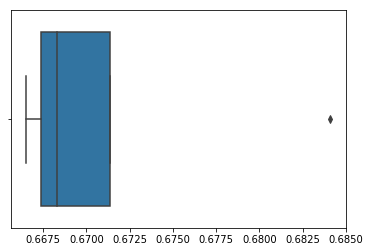

In [222]:
# on mesure la précision du modèle sur 5 subsets de notre jeu de données "train", afin de limiter l'influence des paramètres aléatoires
cv_fold = 5
model = RFClass()
scores = cross_val_score(model, X_train, y_train, cv=cv_fold)

sns.boxplot(scores)

**Note:**
on teste ce modèle sur un réel jeu de test. Il en ressort une précision de 69%, ce qui est cohérent avec le score obtenu sur les données d'entrainement. Néanmoins, la matrice de confusion révèle:
    - 2700 cas de non-fraudes, prédits correctement
    - 2200 cas de fraudes, prédits correctement
    - 910 cas de fausses alertes
    - 1300 cas de fraudes non détectées

la précision sur jeu de test est de 68%


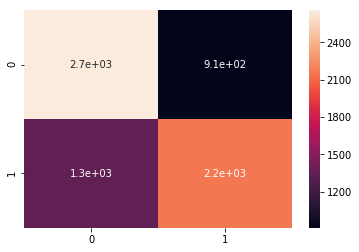

In [224]:
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

score = sum((y_pred == y_test))/len(y_test)
print("la précision sur jeu de test est de {}%".format(round(score * 100)))

from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

<h2> Feature engineering et amélioration du dataset </h2>

1) nous avions éliminé les dates, néanmoins nous pouvons réintégrer certains éléments tels que le temps écoulé entre la création du compte et la date de l'achat. Nous supposons ici qu'un comportement frauduleux pourrait être détecté avec un délai singulier entre la création du compte client et le premier achat. Le graphique boxplot ci dessous semble confirmer que les achats frauduleux (colonne 1) correspondent a des user dont la date de création est proche du premier achat. nous conserverons donc cet éléments dans notre jeu de données



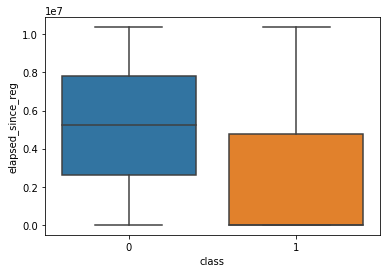

In [367]:
time_delta = pd.to_datetime(sample_data["purchase_time"]) - pd.to_datetime(sample_data["signup_time"])
sample_data["elapsed_since_reg"] = [r.days * 24 * 3600 + r.seconds for r in time_delta]
sns.boxplot(data=sample_data, x = "class", y = "elapsed_since_reg")

2) nous avions éliminé les devices ID car ils n'étaient pas immédiatement exploitable, néanmoins nous pouvons réintégrer certains éléments tels que le nombre d'achats réalisés à partir d'1 seul ID. En effet on peut supposer que les achats frauduleux seront réalisés à partir de robots ou faux utilisateurs provenant d'un device. Le graphique ci dessous semble confirmer que les acheteurs frauduleux tendent à utiliser une meme machine pour un grand nombre d'achats, ce qui est plus exceptionnel chez les acheteurs réels. Nous conserverons donc cet objet dans notre modèle.



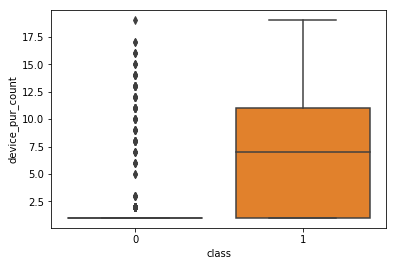

In [368]:
# compter le nombre de transaction par device
#count_by_device = data.groupby(["class","device_id"]).count()
device_count = sample_data['device_id'].value_counts()
sample_data["device_pur_count"] = sample_data.device_id.apply(lambda x: device_count[x])
sns.boxplot(data=sample_data, x = "class", y = "device_pur_count")

3) on note que certains pays concentrent un part importante de transactions frauduleuses...*

In [382]:
country_avg_fraud = sample_data.groupby("country").mean().sort_values("class", ascending = False)
country_sales_count = sample_data.groupby("country").count()
country_avg_fraud = country_avg_fraud.join(country_sales_count, rsuffix = '_r')
country_avg_fraud = country_avg_fraud.loc[:,["class","user_id_r"]]
print(country_avg_fraud.sort_values(["class","user_id_r"],ascending=False).head(20))


                          class  user_id_r
country                                   
Afghanistan            1.000000          1
Turkmenistan           1.000000          1
Virgin Islands (U.S.)  1.000000          1
Honduras               1.000000          1
Malawi                 1.000000          1
Montenegro             1.000000          1
Namibia                0.909091         11
Luxembourg             0.875000         32
Sri Lanka              0.866667         15
Ecuador                0.848485         33
Kuwait                 0.807692         26
Ireland                0.774648         71
Bolivia                0.764706         17
Tunisia                0.756098         41
Peru                   0.756098         41
New Zealand            0.696629         89
Saudi Arabia           0.694444         72
Chile                  0.688172         93
Armenia                0.666667          3
El Salvador            0.666667          3


*...par ailleurs le cas des pays "not found" semble contenir un part équilibrée de fraude et de non fraude (environ 47%) ce qui est cohérent avec l'ensemble du dataset et n'impactera probablement pas la prédiction. On peut donc le conserver dans le jeu de données.


In [385]:
print("cas particulier des pays 'not found'",country_avg_fraud[country_avg_fraud.index == "not_found"])

cas particulier des pays 'not found'               class  user_id_r
country                       
not_found  0.479501       3927


<h2> Nouveau test du modèle avec jeu de données enrichi + optimisation des paramètres</h2>

In [412]:
# on utilise cette fois ci nos données enrichies
new_X = sample_data.drop(["class", "user_id","device_id", "ip_address", "signup_time", "purchase_time"], axis = 1)
new_y = sample_data.loc[:,"class"]

new_X = pd.get_dummies(new_X, drop_first = True)
X_train, X_test, y_train, y_test = train_test_split(new_X,new_y)

from sklearn.model_selection import GridSearchCV

# on mesure la précision du modèle sur 5 subsets de notre jeu de données "train", afin de limiter l'influence des paramètres aléatoires
cv_fold = 5

# on utilise cette fois ci une fonctionnalité GridSearch qui optimisera seule les parametres de notre algo 
param_grid = [
  {'max_features': [6,7,8], 'n_estimators': [100,200,300]},            ]
model = RFClass()

clf = GridSearchCV(model, param_grid, cv=cv_fold)
clf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_features': [6, 7, 8], 'n_estimators': [100, 200, 300]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [408]:
scores = cross_val_score(clf.best_estimator_, X_train, y_train, cv=cv_fold)

*on mesure la précision du modèle avec ces nouveaux paramètres et on constante un gain notable. Le modèle et maintenant précis à 77%

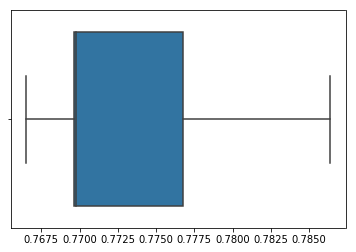

In [409]:
sns.boxplot(scores)

**Note:**
on teste ce modèle sur un réel jeu de test. Il en ressort une précision de 76%, ce qui est cohérent avec le score obtenu sur les données d'entrainement. Néanmoins, la matrice de confusion révèle:
    - 3200 cas de non-fraudes, prédits correctement
    - 2100 cas de fraudes, prédits correctement
    - 350 cas de fausses alertes
    - 1400 cas de nfraudes non détectées
  
Les traitements d'optimisation ont eu un effet positif sur le résultat et ont permis de **diminuer le nombre de fraudes non détectées.**

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


la précision sur jeu de test est de 76%


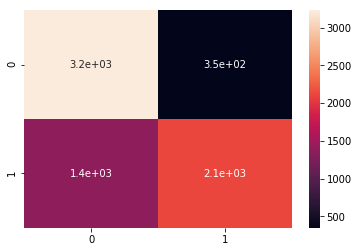

In [410]:
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

score = sum((y_pred == y_test))/len(y_test)
print("la précision sur jeu de test est de {}%".format(round(score * 100)))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

<h2> step 3 => explication de la logique de l'algo 

In [411]:
Dec_tree = DTClass()
Dec_tree.fit(X_train, y_train)
tree.export_graphviz(Dec_tree, out_file='tree2.dot', max_depth = 3, feature_names = X_train.columns) 

*Le fichier tree2.png décrit le cheminement de l'algo. Les principaux critères discrimant pour identifier une fraude principale sont:
    1 - le device_id a été utilisé pour + d'1 commande
    2 - le client arrive sur le site web par acquisition directe
    3 - le temps écoulé entre la création du compte et l'achat est inférieur à 30 heures
    etc..
    

<h2> step 4 => application productive
    

Dans l'état actuel des choses,  l'algorythme ne permet d'identifier que 65% des fraudes environs (2100 sur un total de 3500). Bien que ceci ne soit pas parfait, il est à noté qu'a l'inverse l'algo ne se trompe que dans 10% des cas pour les clients réguliers, ce qui signifie qu'un client sur 10 verrait sa commande mise en attente de validation par le service client par ex., qui pourrait confirmer l'identité de l'acheteur par un moyen tiers (justif domicile etc...)